# Trabalho 3

Bianca Nunes Coelho - 15102880<br>
Raíssa Nunes Coelho - 15102887<br>

## Introdução
No cenário atual de constante fluxo de informações, o jornalismo desempenha um papel crucial na disseminação de notícias e na formação de opinião pública. Com a crescente quantidade de conteúdo jornalístico disponível online, surge a necessidade de técnicas automatizadas para organizar e classificar essas informações de maneira eficiente. Neste projeto, propomos explorar o uso do Processamento de Linguagem Natural (PLN) para classificar textos de matérias jornalísticas de jornais brasileiros, visando aprimorar a organização e a acessibilidade desse conteúdo. <br>

A calssificação de texto é necessária para automatizar a organização e a análise de grandes volumes de dados textuais. A classificação de textos jornalísticos possibilita uma melhor organização do conteúdo, tornando-o mais acessível e útil para os leitores. Além disso, a classificação automática é essencial para a criação de sistemas de recomendação personalizados e para o desenvolvimento de ferramentas de análise de sentimentos e tendências.<br>

O principal objetivo deste projeto é desenvolver modelos de PLN capazes de classificar automaticamente textos de matérias jornalísticas em categorias pré-definidas. Essa classificação facilitará a indexação e a recuperação de informações relevantes, além de permitir análises mais aprofundadas sobre tendências e padrões presentes nas notícias. Assim, buscamos:<br>

  +  Implementar e avaliar diferentes algoritmos de classificação, como Naive Bayes, SVM e Árvores de Decisão. <br>
  +  Analisar e interpretar os resultados obtidos em relação aos objetivos do projeto e às perguntas centrais formuladas. <br>
Para orientar a nossa pesquisa e análise as seuintes perguntas são centrais: <br>
  + Quais algoritmos de classificação de textos apresentam melhor desempenho na identificação de categorias de matérias jornalísticas?
  + Como os resultados obtidos podem contribuir para aprimorar a organização e a acessibilidade do conteúdo jornalístico online?

## Bibliotecas
Bibliotecas necessárias para execução básica dos códigos ficam aqui. Outras são chamadas quando necessário.

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

## Dataset

O dataset está em formato ***parquet***, que é mais eficiente, rápido e compacta mais o tamanho do arquivo. Para ler parquet precisamos de uma engine além do pandas, a escolhida foi pyarrow.</br>

O arquivo de dataset contém matérias jornalisticas tiradas do website CNN Brasil em 2023 no espaço de 1 mês. O autor do dataset se encontra no site da Hugging Face neste link: [cnn_news_ptbr](https://huggingface.co/datasets/celsowm/cnn_news_ptbr).</br>

In [2]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [3]:
len(df)

3877

In [4]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


Como pode-se ver, o dataset possui 3877 linhas e 6 colunas sendo elas: "titulo", "texto", "link", "resumo", "categoria" e "data_hora".

## Balanceamento

Mesmo tendo um dataset pronto para o treinamento de modelos de classificação, precisamos verificar e balanceá-lo para que se diminua desvios e viés ao final do treinamento.</br>

In [5]:
df['categoria'].value_counts()

categoria
esportes           960
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: count, dtype: int64

<Axes: xlabel='categoria'>

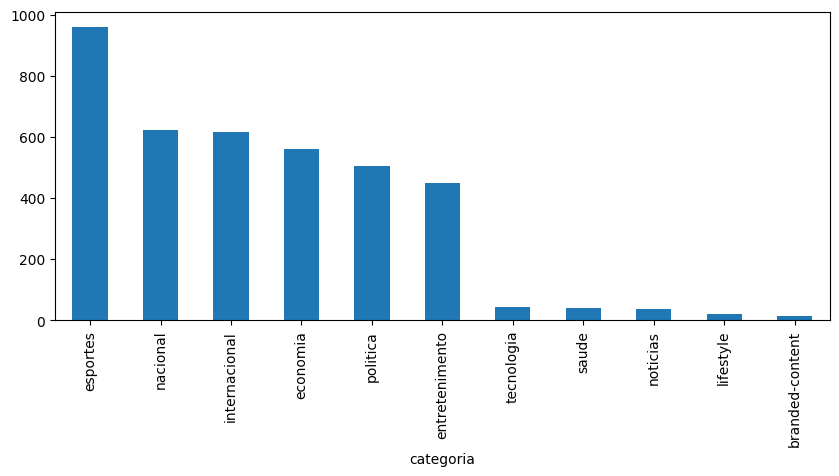

In [6]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

In [7]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [8]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [9]:
df['categoria'].value_counts()

categoria
esportes          960
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: count, dtype: int64

In [10]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [11]:
df_balanceado['categoria'].value_counts()

categoria
esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: count, dtype: int64

In [12]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Veja ex-Vasco sendo furtado durante comemoraçã...,O ex-jogador Pedro Ken passou por momentos de ...,https://www.cnnbrasil.com.br/esportes/veja-ex-...,"Pedro Ken tem passagens pelo Vasco, Coritiba e...",esportes,2023-11-21 12:54:42
1,"Rebaixado, América-MG deve perder dupla de des...",O América-MG já começou o processo de renovaçã...,https://www.cnnbrasil.com.br/esportes/rebaixad...,"Segundo Euler Araújo, membro do Conselho de Ad...",esportes,2023-11-28 19:55:48
2,Novorizontino x Vitória ao vivo: acompanhe o j...,(publicado por Ana Cristina Schwambach),https://www.cnnbrasil.com.br/esportes/novorizo...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-12 18:31:50
3,O pressionado Bahia recebe o São Paulo em reen...,Na luta ponto a ponto para fugir do rebaixamen...,https://www.cnnbrasil.com.br/esportes/o-pressi...,Tricolor baiano é o primeiro time dentro da zo...,esportes,2023-11-29 14:33:38
4,Eliminatórias da Euro: Joia de 16 anos volta a...,A Espanha visitou Chipre na Limassol Arena e v...,https://www.cnnbrasil.com.br/esportes/eliminat...,Lamine Yamal é uma das maiores revelações do país,esportes,2023-11-16 21:13:37


In [13]:
# pega coluna
text = df_balanceado['texto'] # para NLTK
len(text)

2700

## Pré-processamento

In [14]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [15]:
from unidecode import unidecode

for i in range(len(text)):
    text[i] = unidecode(text[i])

In [16]:
for i in range(len(text)):
    text[i] = re.sub(r'[^a-zA-Z\s]', "" ,text[i])

In [17]:
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/raissa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [20]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [21]:
stopwords2 = ["podera", "ja", "assim","dessa","antes","sobre","vai","h","horario","quanto",
              "pode", "tambem", "disso", "ate","leia", "sobre", "contra", "outra", "tera", 
              "nao", "porque","entao", "fim", "ha", "muita", "bem", "assuma", "parece", "chance",
              "diz", "bom", "soma", "mesmos", "p", "mau", "uol", "nada", "desse", "deram"]

for stop in stopwords2:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [22]:
print(token_text[100])

['inglaterra', 'malta', 'enfrentam', 'nesta', 'sextafeira', 'brasilia', 'estadio', 'wembley', 'inglaterra', 'grupo', 'c', 'fase', 'grupos', 'eliminatorias', 'euro', 'jogo', 'transmissao', 'tv', 'aberta', 'torcedor', 'acompanhar', 'confronto', 'sportv', 'canal', 'assinatura', 'globo', 'duelo', 'sera', 'lider', 'lanterna', 'grupo', 'c', 'enquanto', 'inglaterra', 'classificada', 'malta', 'tenta', 'primeira', 'vitoria', 'eliminatorias', 'conteudo', 'criado', 'originalmente', 'itatiaia', 'versao', 'original']


In [48]:
df_balanceado['texto'] = token_text
df_balanceado.head(2)

,categoria,texto,category_id
0,esportes,exjogador pedro ken passou momentos sufoco dur...,0
1,esportes,americamg comecou processo renovacao elenco te...,0


## Treinamento dos Modelos
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb  <br>
refazer para cada biblioteca

### NLTK e Vetorização

In [24]:
for i in range(len(token_text)):
    token_text[i] = " ".join(token_text[i])
print(token_text[0])

exjogador pedro ken passou momentos sufoco durante comemoracao titulo serie b vitoria salvador ultimo sabado torcida lotou barradao vitoria sport dia aproveitado comemoracao titulo serie b havia sido conquistado antecedencia durante entrevista portal noticias bnews alguns torcedores aproximam ken furta celular jogador percebe deixa entrevista atras suspeito veja durante comemoracoes titulo vitoria salvador exjogador pedro ken celular roubado enquanto dava entrevista tv local bnews bnewspictwittercomtkitmg liberta depre libertadepre november acordo reporter responsavel entrevista jogador conseguiu conter suspeito ajuda alguns torcedores homem largou celular pedro recuperou aparelho jogador passagens vitoria coritiba vasco alem pedro ken exjogador diego lugano celular furtado durante comemoracao titulo copa brasil sao paulo setembro ainda conseguiu segurar criminoso recuperar aparelho agosto comentarista domingol exjogador emerson sheik vitima tentativa assalto rio janeiro lugar moro ano

In [25]:
df_balanceado['texto'] = token_text
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Veja ex-Vasco sendo furtado durante comemoraçã...,exjogador pedro ken passou momentos sufoco dur...,https://www.cnnbrasil.com.br/esportes/veja-ex-...,"Pedro Ken tem passagens pelo Vasco, Coritiba e...",esportes,2023-11-21 12:54:42
1,"Rebaixado, América-MG deve perder dupla de des...",americamg comecou processo renovacao elenco te...,https://www.cnnbrasil.com.br/esportes/rebaixad...,"Segundo Euler Araújo, membro do Conselho de Ad...",esportes,2023-11-28 19:55:48
2,Novorizontino x Vitória ao vivo: acompanhe o j...,publicado ana cristina schwambach,https://www.cnnbrasil.com.br/esportes/novorizo...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-12 18:31:50
3,O pressionado Bahia recebe o São Paulo em reen...,luta ponto ponto fugir rebaixamento bahia rece...,https://www.cnnbrasil.com.br/esportes/o-pressi...,Tricolor baiano é o primeiro time dentro da zo...,esportes,2023-11-29 14:33:38
4,Eliminatórias da Euro: Joia de 16 anos volta a...,espanha visitou chipre limassol arena venceu c...,https://www.cnnbrasil.com.br/esportes/eliminat...,Lamine Yamal é uma das maiores revelações do país,esportes,2023-11-16 21:13:37


In [26]:
col = ['categoria', 'texto']
df_balanceado = df_balanceado[col]

In [27]:
df_balanceado.head()

,categoria,texto
0,esportes,exjogador pedro ken passou momentos sufoco dur...
1,esportes,americamg comecou processo renovacao elenco te...
2,esportes,publicado ana cristina schwambach
3,esportes,luta ponto ponto fugir rebaixamento bahia rece...
4,esportes,espanha visitou chipre limassol arena venceu c...


In [28]:
df_balanceado['category_id'] = df_balanceado['categoria'].factorize()[0]
from io import StringIO
category_id_df = df_balanceado[['categoria', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'categoria']].values)
df_balanceado.head()

,categoria,texto,category_id
0,esportes,exjogador pedro ken passou momentos sufoco dur...,0
1,esportes,americamg comecou processo renovacao elenco te...,0
2,esportes,publicado ana cristina schwambach,0
3,esportes,luta ponto ponto fugir rebaixamento bahia rece...,0
4,esportes,espanha visitou chipre limassol arena venceu c...,0


In [29]:
## Bag of Words model - TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=sw)
features = tfidf.fit_transform(df_balanceado['texto']).toarray()
labels = df_balanceado.category_id
features.shape

(2700, 18826)

In [30]:
## Bigramas e Unigramas
from sklearn.feature_selection import chi2
import numpy as np

N = 2

for categoria, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(categoria))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'economia':
  . Most correlated unigrams:
. trimestre
. bilhoes
  . Most correlated bigrams:
. reforma tributaria
. banco central
# 'entretenimento':
  . Most correlated unigrams:
. fas
. cantora
  . Most correlated bigrams:
. shared by
. post shared
# 'esportes':
  . Most correlated unigrams:
. rodada
. campeonato
  . Most correlated bigrams:
. itatiaia versao
. originalmente itatiaia
# 'internacional':
  . Most correlated unigrams:
. gaza
. israel
  . Most correlated bigrams:
. defesa israel
. faixa gaza
# 'nacional':
  . Most correlated unigrams:
. civil
. policia
  . Most correlated bigrams:
. defesa civil
. policia civil
# 'politica':
  . Most correlated unigrams:
. supremo
. stf
  . Most correlated bigrams:
. supremo tribunal
. tribunal federal


### Treinamento

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_balanceado['texto'], df_balanceado['categoria'], random_state = 2)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(dual=False),
    MultinomialNB(), #Naive Bayes
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(random_state=0,max_depth=10),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [33]:
accuracies.std() #standard deviation

0.014103283529377623

In [34]:
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.611111
LinearSVC                 0.913704
LogisticRegression        0.900000
MultinomialNB             0.887407
RandomForestClassifier    0.789259
Name: accuracy, dtype: float64

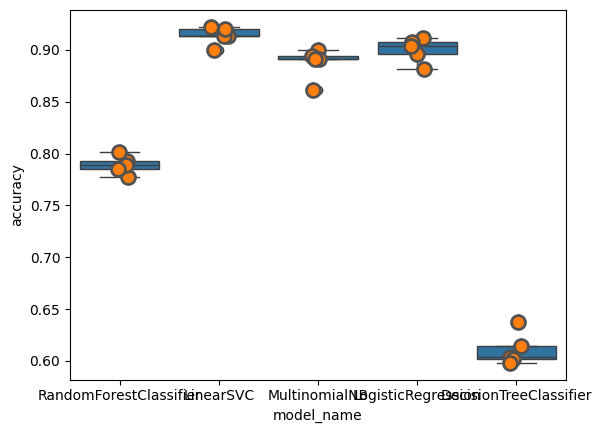

In [35]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, edgecolor="auto", linewidth=2)
plt.show()

### Multinomial NB

In [56]:
## Multinomial NB
from sklearn.model_selection import train_test_split

model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [57]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       1.00      0.91      0.95       140
      nacional       0.82      0.90      0.86       147
 internacional       0.95      0.84      0.89       159
      economia       0.78      0.88      0.83       137
      politica       0.84      0.77      0.80       141
entretenimento       0.91      0.97      0.94       167

      accuracy                           0.88       891
     macro avg       0.88      0.88      0.88       891
  weighted avg       0.89      0.88      0.88       891



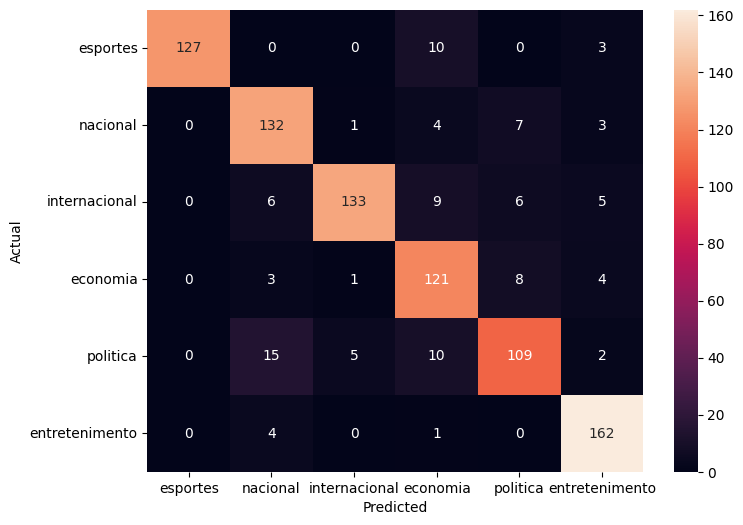

In [58]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### LogisticRegression

In [59]:
from sklearn.model_selection import train_test_split

model2 = LogisticRegression(random_state=0)

X_train2, X_test2, y_train2, y_test2, indices_train2, indices_test2 = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)

In [60]:
from sklearn import metrics
print(metrics.classification_report(y_test2, y_pred2,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       1.00      0.91      0.95       140
      nacional       0.84      0.88      0.86       147
 internacional       0.94      0.86      0.90       159
      economia       0.83      0.88      0.85       137
      politica       0.84      0.78      0.81       141
entretenimento       0.85      0.97      0.91       167

      accuracy                           0.88       891
     macro avg       0.89      0.88      0.88       891
  weighted avg       0.89      0.88      0.88       891



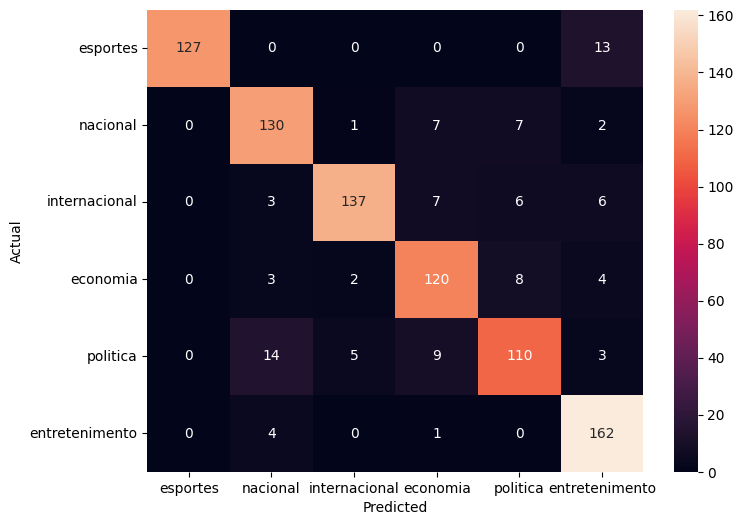

In [61]:
from sklearn.metrics import confusion_matrix

conf_mat2 = confusion_matrix(y_test2, y_pred2)
fig2, ax2 = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat2, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Linear SVC

In [62]:
from sklearn.model_selection import train_test_split

model3 = LinearSVC(dual=False)

X_train3, X_test3, y_train3, y_test3, indices_train3, indices_test3 = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model3.fit(X_train3, y_train3)
y_pred3 = model3.predict(X_test3)

In [63]:
print(metrics.classification_report(y_test3, y_pred3,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       1.00      0.99      0.99       140
      nacional       0.85      0.86      0.86       147
 internacional       0.93      0.89      0.91       159
      economia       0.86      0.88      0.87       137
      politica       0.84      0.81      0.82       141
entretenimento       0.91      0.96      0.94       167

      accuracy                           0.90       891
     macro avg       0.90      0.90      0.90       891
  weighted avg       0.90      0.90      0.90       891



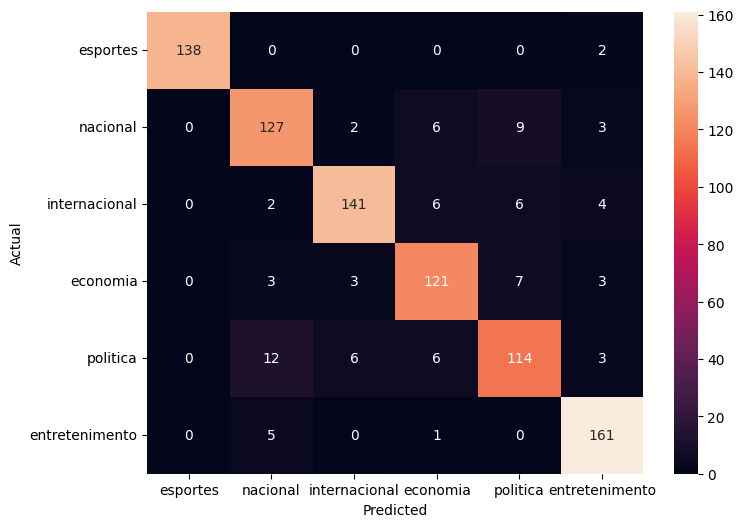

In [64]:
conf_mat3 = confusion_matrix(y_test3, y_pred3)
fig3, ax3 = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat3, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random Forest Classifier

In [65]:
model4 = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

X_train4, X_test4, y_train4, y_test4, indices_train4, indices_test4 = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model4.fit(X_train4, y_train4)
y_pred4 = model4.predict(X_test4)

In [66]:
print(metrics.classification_report(y_test4, y_pred4,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       0.88      0.89      0.88       140
      nacional       0.61      0.80      0.69       147
 internacional       0.92      0.64      0.75       159
      economia       0.69      0.74      0.71       137
      politica       0.72      0.77      0.74       141
entretenimento       0.90      0.80      0.85       167

      accuracy                           0.77       891
     macro avg       0.79      0.77      0.77       891
  weighted avg       0.79      0.77      0.77       891



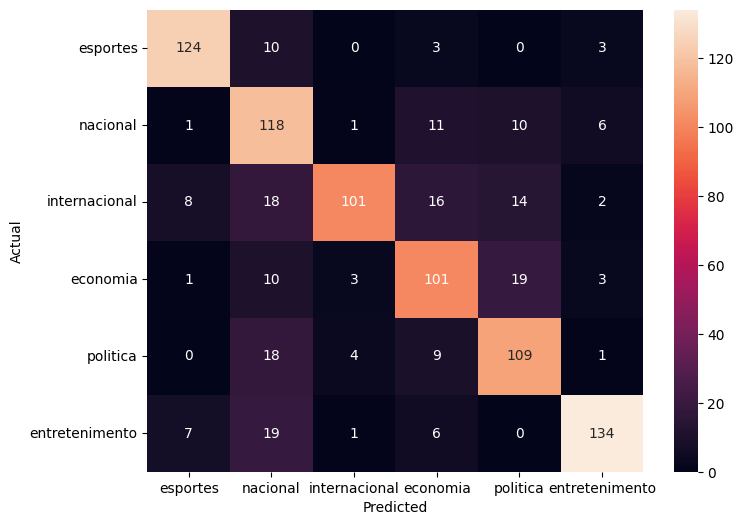

In [67]:
conf_mat4 = confusion_matrix(y_test4, y_pred4)
fig4, ax4 = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat4, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Decision Tree

In [68]:
model5 = DecisionTreeClassifier(random_state=0,max_depth=10)

X_train5, X_test5, y_train5, y_test5, indices_train5, indices_test5 = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model5.fit(X_train5, y_train5)
y_pred5 = model5.predict(X_test5)

In [69]:
print(metrics.classification_report(y_test5, y_pred5, target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       0.98      0.67      0.80       140
      nacional       0.70      0.56      0.62       147
 internacional       0.88      0.53      0.66       159
      economia       0.77      0.36      0.49       137
      politica       0.56      0.66      0.61       141
entretenimento       0.43      0.90      0.58       167

      accuracy                           0.62       891
     macro avg       0.72      0.61      0.63       891
  weighted avg       0.71      0.62      0.63       891



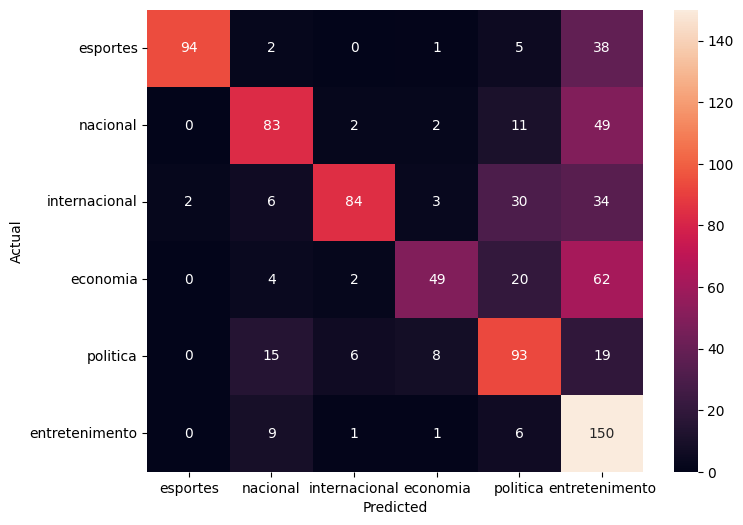

In [70]:
conf_mat5 = confusion_matrix(y_test5, y_pred5)
fig5, ax5 = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat5, annot=True, fmt='d', xticklabels=category_id_df.categoria.values, yticklabels=category_id_df.categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testando o(s) Modelo(s)

### Multinomial NB

In [42]:
texts = [""" França deu o último passo, nesta segunda-feira (4), para se tornar o primeiro país do mundo a prever o acesso ao aborto em sua Constituição.
O Congresso francês, que reúne as duas casas do Parlamento em Versalhes para votação quando há mudanças na Constituição, aprovou por ampla maioria o projeto que constitucionaliza o aborto. Dos 852 deputados e senadores reunidos, 780 votaram a favor e 72 contra.

Após a promulgação pelo presidente francês, o que deve acontecer na sexta-feira (8), Dia da Mulher, o artigo 34.º artigo da Constituição francesa passará a prever a “liberdade garantida da mulher de recorrer ao direito à interrupção voluntária da gravidez [IVG, sigla usada para se referir ao aborto na França]”. 
Raízes históricas por trás da mudança

A decisão, considerada histórica por movimentos feministas e partidos de esquerda, é uma construção de séculos.

A defesa dos direitos femininos na França tem raízes históricas. Já no século XV, a escritora Christine de Pizan defendeu o direito das mulheres à educação. Três séculos depois, Olympe de Gouges criticou a exclusão das mulheres da “Declaração dos Direitos do Homem e do Cidadão” na Revolução Francesa de 1789. E em 1949, no livro “O Segundo Sexo”, Simone de Beauvoir estruturou as bases que definem o feminismo moderno ao discutir a opressão da mulher em um mundo dominado pelo homem.

A França também é o país que, ainda no início do século passado, separou a Igreja do Estado ao aprovar em 1905 a Lei da Laicidade, afastando a religião das discussões políticas. 

Esses são alguns dos fatores que explicam por que 86% dos franceses apoiam a constitucionalização do aborto, como demonstrou uma pesquisa do final de 2022 – taxa bem superior à do Brasil, onde a aprovação ao aborto é de 39%. 

Com o apoio massivo da população francesa, senadores admitiram que votaram a favor do texto para evitar críticas. No último dia 28 de fevereiro, o Senado francês, de maioria direitista, aprovou o projeto por ampla maioria, com 267 votos a favor e 50 contra."""]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'politica'


In [43]:
texts = [""" Mais um preso que fugiu de um presídio na região metropolitana de Belo Horizonte (MG) foi recapturado pela Polícia Militar. Com isso, quatro dos nove fugitivos já foram encontrados.

João Batista Freire Rodrigues Filho foi localizado por policiais na manhã do último domingo (3). Ele estava preso na penitenciária de Santa Luzia, na Grande Belo Horizonte. A fuga ocorreu na última quarta-feira (29).

Segundo a Secretaria de Estado de Justiça e Segurança, o preso foi encontrado em Juatuba, também na região metropolitana de Belo Horizonte. Informações do Disque-Denúncia levaram os agentes a encontrá-lo.Até o momento, a Secretaria de Segurança afirmou que cinco fugitivos ainda não foram localizados. O terceiro recapturado foi encontrado na última sexta-feira (1º) pela Polícia Militar. Os outros dois foram recapturados no mesmo dia da fuga.

Em nota, a pasta ressalta que a população pode continuar ajudando as forças de segurança com informações, por meio do Disque-Denúncia (181). A secretaria afirma que a ligação é gratuita e o canal garante 100% o anonimato do denunciante."""]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'nacional'


In [44]:
texts = ["""A cantora foi expulsa do reality show no último sábado (2), após ser acusada de agressão pelo participante Davi Brito.

Em um vídeo publicado no stories de seu perfil no Instagram, Zilu explicou que as coisas não estão bem no momento. No entanto, garantiu que, em breve, devem melhorar.

“A gente está aqui, enchendo ela de carinho e de amor. Está todo mundo trabalhando, é vida que segue, bola para frente. Deus sabe de todas as coisas, Deus sabe o que é melhor para cada um de nós e Ele age de acordo com aquilo que é melhor pra gente”, afirmou.

Sem mencionar Dado Dolabella, atual namorado de Wanessa, Zilu disse que permanecerá na casa da filha. “Então, a gente não pode julgar, atacar ou fazer nada a não ser orar e deixar tudo nas mãos de Deus. É isso que eu acredito e isso que será feito”, acrescentou. Ao final, a empresária afirmou que aos poucos Camargo está retomando sua rotina. “Agora mesmo ela foi buscar o Joãozinho, ela está a todo vapor. Lógico que as coisas não estão bem, mas vai ficar. Tenho certeza que vai ficar”, concluiu.
A expulsão de Wanessa Camargo

A decisão da produção do BBB 24 sobre a desclassificação de Wanessa aconteceu na tarde do último sábado (2), horas depois de Davi ter dito que a cantora lhe deu um tapa enquanto ele dormia.

“Ela viu que eu estava deitado. São quatro camas naquele quarto, ela veio bater logo na minha cama? Além disso ser provocação, é falta de respeito. Eu estava dormindo, cara. Perdi até o sono”, disse.

“Aí quando você está no seu momento de paz, tem que acontecer. Tem que acontecer alguma coisa, tirar você do sério. Isso não vai ficar de graça não”, afirmou ele. """]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'entretenimento'


### LogisticRegression

In [45]:
texts = [""" França deu o último passo, nesta segunda-feira (4), para se tornar o primeiro país do mundo a prever o acesso ao aborto em sua Constituição.
O Congresso francês, que reúne as duas casas do Parlamento em Versalhes para votação quando há mudanças na Constituição, aprovou por ampla maioria o projeto que constitucionaliza o aborto. Dos 852 deputados e senadores reunidos, 780 votaram a favor e 72 contra.

Após a promulgação pelo presidente francês, o que deve acontecer na sexta-feira (8), Dia da Mulher, o artigo 34.º artigo da Constituição francesa passará a prever a “liberdade garantida da mulher de recorrer ao direito à interrupção voluntária da gravidez [IVG, sigla usada para se referir ao aborto na França]”. 
Raízes históricas por trás da mudança

A decisão, considerada histórica por movimentos feministas e partidos de esquerda, é uma construção de séculos.

A defesa dos direitos femininos na França tem raízes históricas. Já no século XV, a escritora Christine de Pizan defendeu o direito das mulheres à educação. Três séculos depois, Olympe de Gouges criticou a exclusão das mulheres da “Declaração dos Direitos do Homem e do Cidadão” na Revolução Francesa de 1789. E em 1949, no livro “O Segundo Sexo”, Simone de Beauvoir estruturou as bases que definem o feminismo moderno ao discutir a opressão da mulher em um mundo dominado pelo homem.

A França também é o país que, ainda no início do século passado, separou a Igreja do Estado ao aprovar em 1905 a Lei da Laicidade, afastando a religião das discussões políticas. 

Esses são alguns dos fatores que explicam por que 86% dos franceses apoiam a constitucionalização do aborto, como demonstrou uma pesquisa do final de 2022 – taxa bem superior à do Brasil, onde a aprovação ao aborto é de 39%. 

Com o apoio massivo da população francesa, senadores admitiram que votaram a favor do texto para evitar críticas. No último dia 28 de fevereiro, o Senado francês, de maioria direitista, aprovou o projeto por ampla maioria, com 267 votos a favor e 50 contra."""]
text_features = tfidf.transform(texts)
predictions2 = model2.predict(text_features)
for text, predicted in zip(texts, predictions2):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'politica'


In [46]:
texts = [""" Mais um preso que fugiu de um presídio na região metropolitana de Belo Horizonte (MG) foi recapturado pela Polícia Militar. Com isso, quatro dos nove fugitivos já foram encontrados.

João Batista Freire Rodrigues Filho foi localizado por policiais na manhã do último domingo (3). Ele estava preso na penitenciária de Santa Luzia, na Grande Belo Horizonte. A fuga ocorreu na última quarta-feira (29).

Segundo a Secretaria de Estado de Justiça e Segurança, o preso foi encontrado em Juatuba, também na região metropolitana de Belo Horizonte. Informações do Disque-Denúncia levaram os agentes a encontrá-lo.Até o momento, a Secretaria de Segurança afirmou que cinco fugitivos ainda não foram localizados. O terceiro recapturado foi encontrado na última sexta-feira (1º) pela Polícia Militar. Os outros dois foram recapturados no mesmo dia da fuga.

Em nota, a pasta ressalta que a população pode continuar ajudando as forças de segurança com informações, por meio do Disque-Denúncia (181). A secretaria afirma que a ligação é gratuita e o canal garante 100% o anonimato do denunciante."""]
text_features2 = tfidf.transform(texts)
predictions2 = model2.predict(text_features)
for text, predicted in zip(texts, predictions2):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'politica'


In [47]:
texts = ["""A cantora foi expulsa do reality show no último sábado (2), após ser acusada de agressão pelo participante Davi Brito.

Em um vídeo publicado no stories de seu perfil no Instagram, Zilu explicou que as coisas não estão bem no momento. No entanto, garantiu que, em breve, devem melhorar.

“A gente está aqui, enchendo ela de carinho e de amor. Está todo mundo trabalhando, é vida que segue, bola para frente. Deus sabe de todas as coisas, Deus sabe o que é melhor para cada um de nós e Ele age de acordo com aquilo que é melhor pra gente”, afirmou.

Sem mencionar Dado Dolabella, atual namorado de Wanessa, Zilu disse que permanecerá na casa da filha. “Então, a gente não pode julgar, atacar ou fazer nada a não ser orar e deixar tudo nas mãos de Deus. É isso que eu acredito e isso que será feito”, acrescentou. Ao final, a empresária afirmou que aos poucos Camargo está retomando sua rotina. “Agora mesmo ela foi buscar o Joãozinho, ela está a todo vapor. Lógico que as coisas não estão bem, mas vai ficar. Tenho certeza que vai ficar”, concluiu.
A expulsão de Wanessa Camargo

A decisão da produção do BBB 24 sobre a desclassificação de Wanessa aconteceu na tarde do último sábado (2), horas depois de Davi ter dito que a cantora lhe deu um tapa enquanto ele dormia.

“Ela viu que eu estava deitado. São quatro camas naquele quarto, ela veio bater logo na minha cama? Além disso ser provocação, é falta de respeito. Eu estava dormindo, cara. Perdi até o sono”, disse.

“Aí quando você está no seu momento de paz, tem que acontecer. Tem que acontecer alguma coisa, tirar você do sério. Isso não vai ficar de graça não”, afirmou ele. """]
text_features2 = tfidf.transform(texts)
predictions2 = model.predict(text_features2)
for text, predicted in zip(texts, predictions2):
  #print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))

  - Predicted as: 'entretenimento'


## Conclusão

## Referências

Dien, Tran Thanh; Loc, Bui Huu; Thai-Nghe, Nguyen  (2019).  [IEEE 2019 International Conference on Advanced Computing and Applications (ACOMP) - Nha Trang, Vietnam (2019.11.26-2019.11.28)] 2019 International Conference on Advanced Computing and Applications (ACOMP) - Article Classification using Natural Language Processing and Machine Learning.,(),78–84.doi:10.1109/acomp.2019.00019 <br>
F. Miao, P. Zhang, L. Jin and H. Wu, "Chinese News Text Classification Based on Machine Learning Algorithm," 2018 10th International Conference on Intelligent Human-Machine Systems and Cybernetics (IHMSC), Hangzhou, China, 2018, pp. 48-51, doi: 10.1109/IHMSC.2018.10117. keywords: {Text categorization;Classification algorithms;Machine learning algorithms;Training;Support vector machines;Bayes methods;Computational modeling;Chinese text classification;Chinese word segment;Feature extraction;Machine learning algorithm},<br>